# Extraction des informations pour Oralia

In [1]:
import pandas as pd
import numpy as np
import pdfplumber
from pathlib import Path
from pydantic import BaseModel, field_validator

In [2]:
from pdf_oralia.extract import extract_table_settings, extract_date, extract_building
from pdf_oralia.pages import locataire, charge, patrimoine

In [3]:
pdf_file = Path("./datas/pdfs/2023/2023 03 Servient.pdf")
# pdf_file = Path("/home/lafrite/Nextcloud/PLESNA Compta SYSTEM/Histoire/CRG/2024/PDF Oralia/2024 10 Servient.pdf")  
pdf = pdfplumber.open(pdf_file)

In [4]:
xls_charge = f"{pdf_file.stem.replace(' ', '_')}_charge.xlsx"
xls_locataire = f"{pdf_file.stem.replace(' ', '_')}_locataire.xlsx"

## Page 1: Récapitulatif

In [5]:
p1 = pdf.pages[0]

In [6]:
"SITUATION DES LOCATAIRES" in p1.extract_text()

False

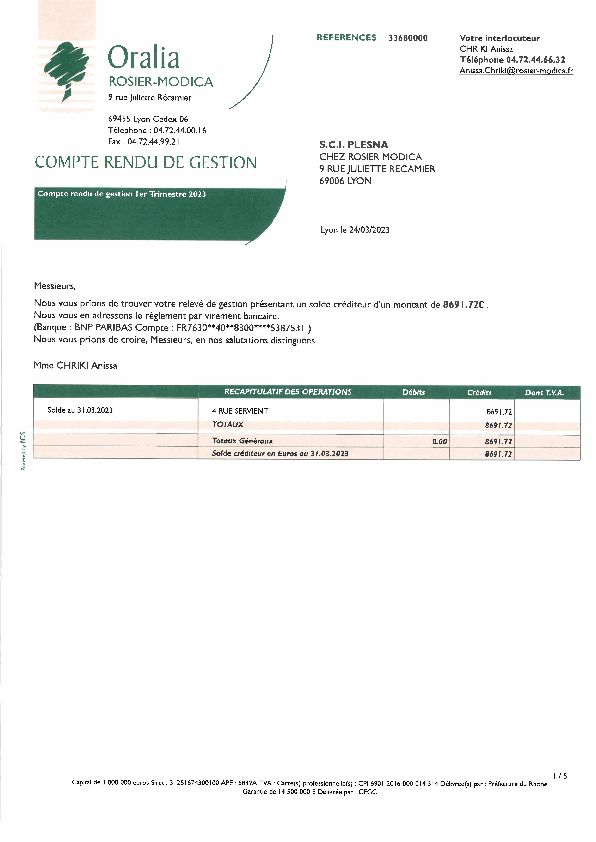

In [7]:
p1.to_image()

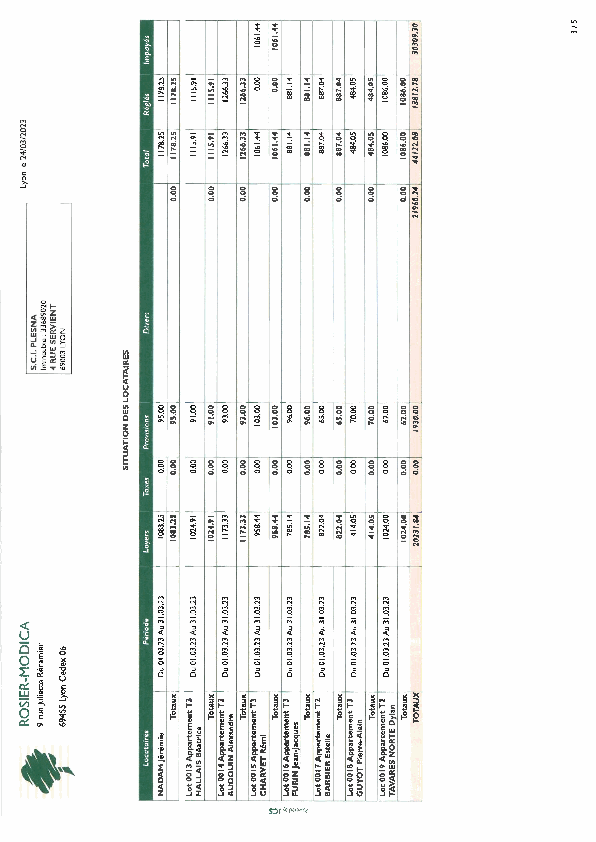

In [8]:
table_settings = {
    "vertical_strategy": "text",
    "horizontal_strategy": "text",
}
page = 2
p = pdf.pages[page]
img = p.to_image()
img.debug_tablefinder(table_settings)
#img.show()

##  Situation des locataires

In [ ]:
class LocataireLine(BaseModel):
    mois: int
    annee: int
    immeuble: str
    Lot: str
    Type: str
    Locataire: str
    Loyers: float
    Taxes: float
    Provisions: float
    Divers: float
    Total: float
    Réglés: float
    Impayés: float
    
    @field_validator('Loyers', 'Taxes', 'Provisions', 'Divers', 'Total', 'Réglés', 'Impayés', mode='before')
    def set_default_if_empty(cls, v):
        if v == '':
            return 0
        return v

class ChargeLine(BaseModel):
    mois: int
    annee: int
    immeuble: str
    lot: str
    Champs: str
    Categorie: str
    Fournisseur: str
    Libellé: str
    Débit: float
    Crédits: float
    Dont_TVA: float
    Locatif: float
    Déductible: float

    @field_validator('Débit', 'Crédits', 'Dont_TVA', 'Locatif', 'Déductible', mode='before')
    def set_default_if_empty(cls, v):
        if v == '':
            return 0
        return v
        
class PatrimoineLine(BaseModel):
    mois: int
    annee: int
    immeuble: str
    Etage: str
    Lot: str
    Type: str
    Locataire: str
    Loyer_annuel: int
    Debut_bail: str
    Fin_bail: str
    Entree: str
    Depart: str
    Revision_bail: str
    Usage: str
    Depot_garantie: float
    
    @field_validator('Loyer_annuel', 'Depot_garantie', mode='before')
    def set_default_if_empty(cls, v):
        if v == '':
            return 0
        return v

In [201]:
def pdf_extract_tables_lines(pdf):
    loc_sink = fsm_locataire()
    next(loc_sink)    
    charge_sink = fsm_charge()
    next(charge_sink)
    patrimoine_sink = fsm_patrimoine()
    next(patrimoine_sink)

    for page in pdf.pages:
        page_text = page.extract_text()
        date = extract_date(page_text)
        additionnal_fields = {
            "immeuble": extract_building(page_text),
            "mois": date.strftime("%m"),
            "annee": date.strftime("%Y"),
        }

        for line in page.extract_table(extract_table_settings):
            if locataire.is_it(page_text):
                res = loc_sink.send(line)
                if res:
                    res.update(additionnal_fields)
                    yield LocataireLine(**res)
            elif charge.is_it(page_text):
                res = charge_sink.send(line)
                if res:
                    res.update(additionnal_fields)
                    yield ChargeLine(**res)
                    
            elif patrimoine.is_it(page_text):
                res = patrimoine_sink.send(line)
                if res:
                    res.update(additionnal_fields)
                    yield PatrimoineLine(**res)
            else:
                print("Unknown page")

In [202]:
HEADER_LOC = ['Locataires', 'Période', 'Loyers', 'Taxes', 'Provisions', 'Divers', '', 'Total', 'Réglés', 'Impayés']

def fsm_locataire():
    current_state = "new_row"
    row = {}
    line = yield
    while True:
        if line == HEADER_LOC:
            line = yield
        elif current_state == "new_row":
            if line[0] != "" and line[0] != "TOTAUX":
                row.update(locataire.parse_lot(line[0]))
                current_state = "add_loc"
            line = yield
        elif current_state == "add_loc":
            if line[0] != "":
                row["Locataire"] = line[0]
                current_state = "add_totaux"
            line = yield
        elif current_state == "add_totaux":
            if line[0] == "Totaux":
                row.update({
                    "Loyers": line[2],
                    "Taxes": line[3],
                    "Provisions": line[4],
                    "Divers": line[5],
                    "Total": line[7],
                    "Réglés": line[8],
                    "Impayés": line[9],
                })
                line = yield row
                row = {}
                current_state = "new_row"
            else:
                line = yield


In [203]:
HEADER_CHARGE = ['', 'RECAPITULATIF DES OPERATIONS', 'Débits', 'Crédits', 'Dont T.V.A.', 'Locatif', 'Déductible']

def fsm_charge():
    current_state = "total"
    row = {}
    line = yield
    while True:
        if line == HEADER_CHARGE:
            line = yield
        if current_state == "total":
            if line[1].lower().split(" ")[0] in ['total', 'totaux']:
                current_state = "new_champs"
            line = yield
        elif current_state == "new_champs":
            if line[0] != "":
                current_state = "new_cat"
                row.update({"Champs": line[0]})
                categorie = line[1]
            line = yield
        elif current_state == "new_cat": 
            if line[1] != "":
                current_state = "new_line"
                row.update({"Categorie": line[1]})
            elif line[0] != "":
                current_state = "new_line"
                row.update({"Categorie": line[0]})
            line = yield
        elif current_state == "new_line":
            if line[1].lower().split(" ")[0] in ['total', 'totaux']:
                current_state = "new_champs"
                line = yield
            elif line[2] != "" or line[3] != "":
                row.update({
                    "Fournisseur": line[0] if line[0]!='' else row["Fournisseur"],
                    "Libellé": line[1],
                    "lot": charge.get_lot(line[1]),
                    "Débit": line[2],
                    "Crédits": line[3],
                    "Dont_TVA": line[4],
                    "Locatif": line[5],
                    "Déductible": line[6] 
                })
                line = yield row
            elif line[0] != "":
                row.update({"Fournisseur": line[0]})
                line = yield
            else:
                line = yield

In [204]:
HEADER_PATRIMOINE = ['Etage', 'Lots', 'Type de lot', 'Nom du Locataire', 'Loyer Annuel', 'Début Bail', 'Fin Bail', 'Entrée', 'Départ', 'Révisé le', 'U', 'Dépôt Gar.']

def fsm_patrimoine():
    current_state = "new_line"
    row = {}
    line = yield
    while True:
        if line == HEADER_PATRIMOINE:
            line = yield
        if current_state == "new_line":
            if line[0]!='':
                row = {
                    "Etage": line[0],
                    "Lot": line[1][-2:],
                    "Type": line[2],
                    "Locataire": line[3],
                    "Loyer_annuel": line[4].replace(" ", ""),
                    "Debut_bail": line[5],
                    "Fin_bail": line[6],
                    "Entree": line[7],
                    "Depart": line[8],
                    "Revision_bail": line[9],
                    "Usage": line[10],
                    "Depot_garantie": line[11].replace(" ", "")
                }
                line = yield row
            else:
                line = yield

In [205]:
for l in pdf_extract_tables_lines(pdf):
    print(l)
    

Unknown page
Unknown page
Unknown page
Unknown page
Unknown page
Unknown page
Unknown page
Unknown page
Unknown page
Unknown page
mois=7 annee=2023 immeuble='bloch' Lot='01' Type='Appartement T3' Locataire='PASQUIER BENJAMIN' Loyers=990.0 Taxes=0.0 Provisions=47.0 Divers=0.0 Total=1037.0 Réglés=518.5 Impayés=518.5
mois=7 annee=2023 immeuble='bloch' Lot='02' Type='Appartement T1' Locataire='LEMOINE YANNICK' Loyers=470.64 Taxes=0.0 Provisions=27.0 Divers=0.0 Total=497.64 Réglés=497.64 Impayés=0.0
mois=7 annee=2023 immeuble='bloch' Lot='03' Type='Appartement T1' Locataire='RIBOLZI MAIA' Loyers=584.74 Taxes=0.0 Provisions=27.0 Divers=0.0 Total=691.37 Réglés=592.0 Impayés=99.37
mois=7 annee=2023 immeuble='bloch' Lot='04' Type='Appartement T1' Locataire='SAHINOVIC MIROSLAV' Loyers=643.73 Taxes=0.0 Provisions=28.0 Divers=0.0 Total=671.73 Réglés=671.73 Impayés=0.0
mois=7 annee=2023 immeuble='bloch' Lot='05' Type='Appartement T2' Locataire='RIGAUDIE AUGUSTE' Loyers=923.92 Taxes=0.0 Provisions=1